# Question 2


In [1]:
import gym
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

### Confused Agent

In [2]:
#create a ConfusedAgent, which randomly picks an action available from a given state
def confused_agent(env_name):
    env = gym.make(env_name)
    obs = env.reset()
    done = False
    total_reward = 0
    total_steps = 0
    while not done and total_steps < 5:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        total_reward += reward
        total_steps += 1
        env.render()
        #when we reach goal, we reset the environment
        if done:
            obs = env.reset()
    env.close()
    print("Total reward: ", total_reward)
    print("Total steps: ", total_steps)

confused_agent('Taxi-v3')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Total reward:  -14
Total steps:  5


### ON-Policy Monte Carlo

Average reward over the runs: 


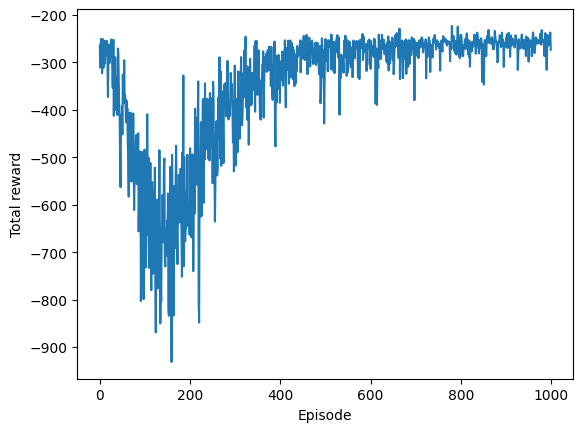

----------------------------------
Mean of best episode rewards:  -58.0
Mean of best episodes:  449.4
----------------------------------
Number of unique states covered vs total reward


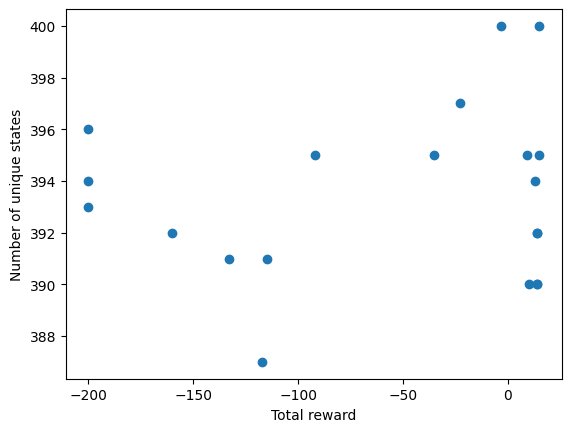

In [13]:
"""
Implementing On-Policy Monte Carlo Control
"""

class OnPolicyMonteCarloAgent:
    def __init__(self, env_name, gamma=0.95, epsilon=0.1):
        self.env = gym.make(env_name)
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # eexploration rate
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # Q table
        self.N = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # N table
        self.policy = self.create_epsilon_soft_policy() # epsilon-soft policy
        self.returns = {(s,a):[] for s in range(self.env.observation_space.n) for a in range(self.env.action_space.n)} # dictionary of lists of returns for each state-action pair

    def create_epsilon_soft_policy(self):
        #returns an epsilon-soft policy
        def policy(state):
            action_probs = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
            best_action = np.argmax(self.Q[state])
            action_probs[best_action] += (1.0 - self.epsilon)
            return action_probs
        return policy
    
    def choose_action(self, state):
        #returns an action given a state based on the epsilon-soft policy
        action_probs = self.policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return action
    
    #update Q table based on the episode
    def learn(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            G = sum(rewards[i:]*discounts[:-(1+i)])
            self.N[state, actions[i]] += 1
            alpha = 1.0 / self.N[state, actions[i]]
            self.Q[state, actions[i]] += alpha * (G - self.Q[state, actions[i]])

    def run(self, num_episodes=200):
        rewards = []
        unique_states = set()
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_rewards = []
            episode_states = []
            episode_actions = []
            covered_states = set()
            while not done:
                action = self.choose_action(state) #choose an action
                next_state, reward, done, info = self.env.step(action) #take action
                episode_rewards.append(reward) #store reward
                episode_states.append(state) #store state
                episode_actions.append(action) #store action
                covered_states.add(state) #add state to covered states
                state = next_state #update state
            episode_rewards = np.array(episode_rewards)
            rewards.append(sum(episode_rewards)) 
            if sum(episode_rewards) > best_episode_reward:
                best_episode_reward = sum(episode_rewards)
                best_episode = episode
            self.learn(zip(episode_states, episode_actions, episode_rewards)) #update Q table
            unique_states.update(covered_states) #add covered states to unique states
        return rewards, best_episode_reward, best_episode, len(unique_states)
    
#Function to plot the rewards(over N runs) vs episodes during training
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.show()

runs = 20
num_episodes = 1000
on_monte_carlo_rewards = np.zeros((runs, num_episodes))
on_monte_carlo_best_episode_rewards = np.zeros(runs)
on_monte_carlo_best_episodes = np.zeros(runs)
on_monte_carlo_unique_states = np.zeros(runs)

for run in range(runs):
    agent = OnPolicyMonteCarloAgent('Taxi-v3') 
    on_monte_carlo_rewards[run, :], on_monte_carlo_best_episode_rewards[run], on_monte_carlo_best_episodes[run], on_monte_carlo_unique_states[run] = agent.run(num_episodes)

#We plot the average reward over the N runs
print("Average reward over the runs: ")
plot_rewards(np.mean(on_monte_carlo_rewards, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained
print("Mean of best episode rewards: ", np.mean(on_monte_carlo_best_episode_rewards))
print("Mean of best episodes: ", np.mean(on_monte_carlo_best_episodes))

print("----------------------------------")

#We plot number of unique states covered in the rollout vs total reward
print("Number of unique states covered vs total reward")
plt.scatter(on_monte_carlo_best_episode_rewards, on_monte_carlo_unique_states)
plt.xlabel("Total reward")
plt.ylabel("Number of unique states")
plt.show()



### OFF-Policy Monte Carlo Using Importance Sampling

/tmp/ipykernel_723180/3457585824.py:46: RuntimeWarning: overflow encountered in double_scalars
  W = W * 1.0 / self.behavior_policy(state)[action]
/tmp/ipykernel_723180/3457585824.py:44: RuntimeWarning: invalid value encountered in double_scalars
  self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])
/tmp/ipykernel_723180/3457585824.py:43: RuntimeWarning: overflow encountered in double_scalars
  self.C[state, action] += W


Average reward over the runs


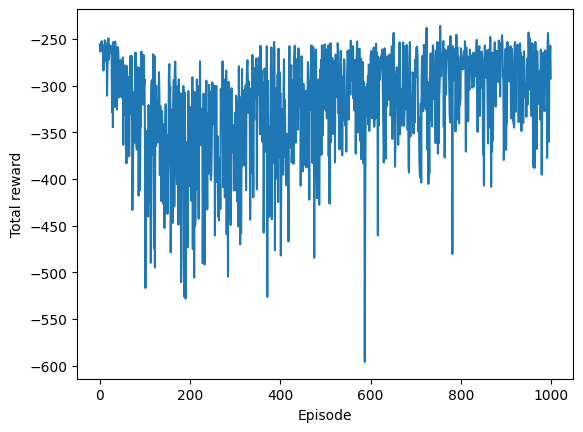

----------------------------------
Mean of best episode rewards:  -51.65
Mean of best episodes:  469.9
----------------------------------
Number of unique states covered vs total reward


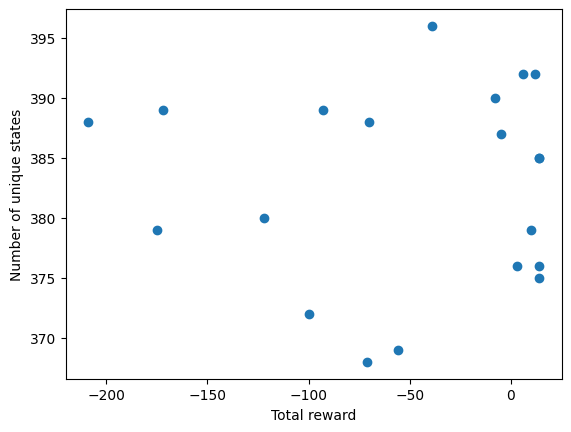

In [14]:
#https://www.andrew.cmu.edu/course/10-403/slides/S19_lecture4_MC.pdf

"""
Implementing Off-Policy Monte Carlo Control
"""

class OffPolicyMonteCarloAgent:
    def __init__(self, env_name, gamma=0.95, epsilon=0.1):
        self.env = gym.make(env_name)
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # eexploration rate
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # Q table
        self.C = np.zeros([self.env.observation_space.n, self.env.action_space.n]) # C table
        self.target_policy = self.create_epsilon_soft_policy() # target policy (can be any arbitrary policy)
        self.behavior_policy = self.create_epsilon_soft_policy() # behavior policy
        self.returns = {(s,a):[] for s in range(self.env.observation_space.n) for a in range(self.env.action_space.n)} # dictionary of lists of returns for each state-action pair

    def create_epsilon_soft_policy(self):
        def policy(state):
            action_probs = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
            best_action = np.argmax(self.Q[state])
            action_probs[best_action] += (1.0 - self.epsilon)
            return action_probs
        return policy
    
    def choose_action(self, state, policy):
        #returns an action given a state based on a given policy
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return action
    
    #update Q table based on the episode
    def learn(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        W = 1.0
        G = 0
        for i in reversed(range(len(states))):
            state = states[i]
            action = actions[i]
            reward = rewards[i]
            G = self.gamma * G + reward
            self.C[state, action] += W
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])
            self.returns[(state, action)].append(G)
            W = W * 1.0 / self.behavior_policy(state)[action]
            if self.target_policy(state)[action] != self.behavior_policy(state)[action]:
                break

    def run(self, num_episodes=200):
        rewards = []
        unique_states = set()
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_rewards = []
            episode_states = []
            episode_actions = []
            covered_states = set()
            while not done:
                action = self.choose_action(state, self.behavior_policy)
                next_state, reward, done, info = self.env.step(action)
                episode_rewards.append(reward)
                episode_states.append(state)
                episode_actions.append(action)
                covered_states.add(state) #we add the state to the set of covered states
                state = next_state
            episode_rewards = np.array(episode_rewards)
            rewards.append(sum(episode_rewards))
            if sum(episode_rewards) > best_episode_reward:
                best_episode_reward = sum(episode_rewards)
                best_episode = episode
            self.learn(zip(episode_states, episode_actions, episode_rewards))
            unique_states.update(covered_states)
        return rewards, best_episode_reward, best_episode, len(unique_states)
    
#Function to plot the rewards(over N runs) vs episodes during training
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.show()

runs = 20
num_episodes = 1000
off_policy_monte_carlo_rewards = np.zeros((runs, num_episodes))
off_policy_monte_carlo_best_episode_rewards = np.zeros(runs)
off_policy_monte_carlo_best_episodes = np.zeros(runs)
off_policy_monte_carlo_unique_states = np.zeros(runs)

for run in range(runs):
    agent = OffPolicyMonteCarloAgent('Taxi-v3')
    off_policy_monte_carlo_rewards[run, :], off_policy_monte_carlo_best_episode_rewards[run], off_policy_monte_carlo_best_episodes[run], off_policy_monte_carlo_unique_states[run] = agent.run(num_episodes)

#We plot the average reward over the N runs
print("Average reward over the runs")
plot_rewards(np.mean(off_policy_monte_carlo_rewards, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained
print("Mean of best episode rewards: ", np.mean(off_policy_monte_carlo_best_episode_rewards))
print("Mean of best episodes: ", np.mean(off_policy_monte_carlo_best_episodes))

print("----------------------------------")

#We plot number of unique states covered in the rollout vs total reward
print("Number of unique states covered vs total reward")
plt.scatter(off_policy_monte_carlo_best_episode_rewards, off_policy_monte_carlo_unique_states)
plt.xlabel("Total reward")
plt.ylabel("Number of unique states")
plt.show()


### Q-Learning

Average reward over the runs: 


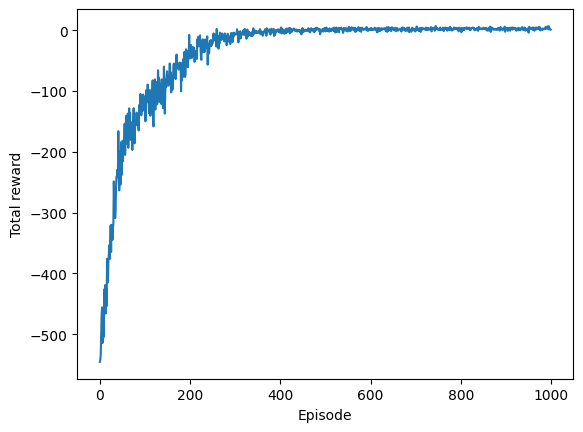

----------------------------------
Mean of best episode rewards:  15.0
Mean of best episodes:  302.5
----------------------------------


In [15]:
"""
Implementing Q-Learning
"""

class QLearningAgent:
    def __init__(self, env_name, alpha=0.5, gamma=0.95, epsilon=0.1):
        self.env = gym.make(env_name)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.alpha = alpha #learning rate
        self.gamma = gamma #discount factor
        self.epsilon = epsilon #exploration rate

    def choose_action(self, state): 
        #returns an action given a state based on the epsilon-greedy policy
        if random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.env.action_space.n) 
        else:
            action = np.argmax(self.Q[state, :])
        return action
    
    def learn(self, state, action, reward, next_state):
        #update Q table
        self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.gamma * np.max(self.Q[next_state, :]) - self.Q[state, action])
        
    def run(self, num_episodes=1000):
        rewards = []
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state) #choose an action
                next_state, reward, done, info = self.env.step(action) #take action
                self.learn(state, action, reward, next_state) #update Q table
                state = next_state #update state
                total_reward += reward #update total reward
            rewards.append(total_reward)
            if total_reward > best_episode_reward:
                best_episode_reward = total_reward
                best_episode = episode
        return rewards, best_episode_reward, best_episode
    
#Function to plot the rewards(over N runs) vs episodes during training
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.show()

runs = 20
num_episodes = 1000
q_learn_rewards = np.zeros((runs, num_episodes))
q_learn_best_episode_rewards = np.zeros(runs)
q_learn_best_episodes = np.zeros(runs)

for run in range(runs):
    agent = QLearningAgent('Taxi-v3') 
    q_learn_rewards[run, :], q_learn_best_episode_rewards[run], q_learn_best_episodes[run] = agent.run(num_episodes)
    
#We plot the average reward over the N runs
print("Average reward over the runs: ")
plot_rewards(np.mean(q_learn_rewards, axis=0)) 

print("----------------------------------")

#We print the best reward and the episode in which it was obtained

print("Mean of best episode rewards: ", np.mean(q_learn_best_episode_rewards))
print("Mean of best episodes: ", np.mean(q_learn_best_episodes))

print("----------------------------------")

### SARSA

Average reward over the runs: 


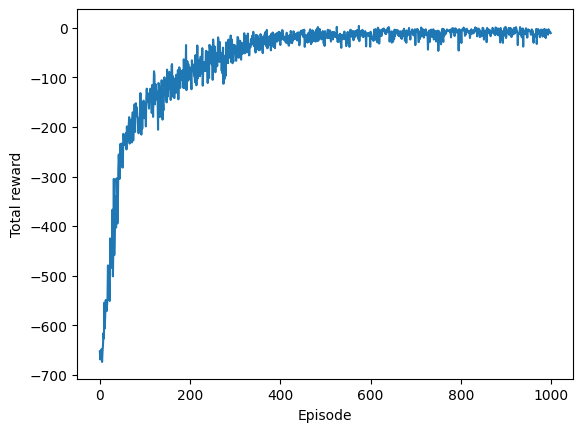

----------------------------------
Mean of best episode rewards:  14.95
Mean of best episodes:  345.75
----------------------------------


In [16]:
"""
Implementing Sarsa
"""

class SarsaAgent:
    def __init__(self, env_name, alpha=0.5, gamma=0.95, epsilon=0.1):
        self.env = gym.make(env_name)
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.alpha = alpha #learning rate
        self.gamma = gamma #discount factor
        self.epsilon = epsilon #exploration rate

    def choose_action(self, state): 
        #returns an action given a state based on the epsilon-greedy policy
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q[state, :])
        return action
    
    def learn(self, state, action, reward, next_state, next_action):
        #update Q table
        self.Q[state, action] = self.Q[state, action] + self.alpha * (reward + self.gamma * self.Q[next_state, next_action] - self.Q[state, action])
        
    def run(self, num_episodes=1000):
        rewards = []
        best_episode_reward = -1000
        best_episode = 0
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            action = self.choose_action(state)
            while not done:
                next_state, reward, done, info = self.env.step(action) #take action
                next_action = self.choose_action(next_state) #choose next action
                self.learn(state, action, reward, next_state, next_action) #update Q table
                state = next_state #update state
                action = next_action #update action
                total_reward += reward #update total reward
            rewards.append(total_reward)
            if total_reward > best_episode_reward:
                best_episode_reward = total_reward
                best_episode = episode
        return rewards, best_episode_reward, best_episode
    
#Function to plot the rewards(over N runs) vs episodes during training
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.show()

runs = 20
num_episodes = 1000
sarsa_rewards = np.zeros((runs, num_episodes))
sarsa_best_episode_rewards = np.zeros(runs)
sarsa_best_episodes = np.zeros(runs)

for run in range(runs):
    agent = SarsaAgent('Taxi-v3') 
    sarsa_rewards[run, :], sarsa_best_episode_rewards[run], sarsa_best_episodes[run] = agent.run(num_episodes)

#We plot the average reward over the N runs
print("Average reward over the runs: ")
plot_rewards(np.mean(sarsa_rewards, axis=0))

print("----------------------------------")

#We print the best reward and the episode in which it was obtained

print("Mean of best episode rewards: ", np.mean(sarsa_best_episode_rewards))
print("Mean of best episodes: ", np.mean(sarsa_best_episodes))

print("----------------------------------")

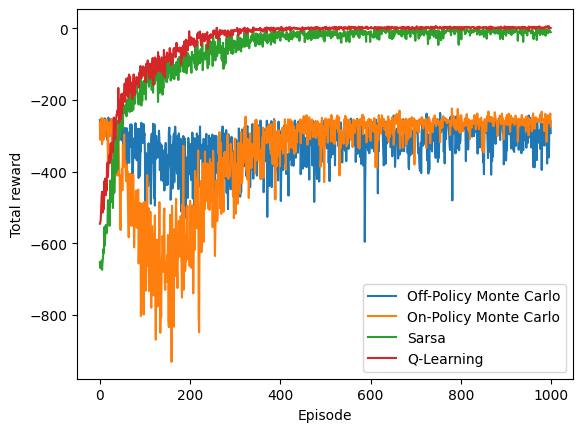

In [19]:
#plot all 4 curves
plt.plot(np.mean(off_policy_monte_carlo_rewards, axis=0), label="Off-Policy Monte Carlo")
plt.plot(np.mean(on_monte_carlo_rewards, axis=0), label="On-Policy Monte Carlo")
plt.plot(np.mean(sarsa_rewards, axis=0), label="Sarsa")
plt.plot(np.mean(q_learn_rewards, axis=0), label="Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.show()


## Analysis:
Q-Learning performs the best out of the 4 methods. It can be clearly seen in the graph as well.
It gets the best possible reward in the least number of episodes based on about $20$ runs of all the 4 models. 